# import packages and functions

In [1]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import scanpy as sc
from scipy.sparse import csr_matrix

#from matplotlib_scalebar.scalebar import ScaleBar

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 1000)

def sort_cnt(arr):
    npcnt=np.array(np.unique(arr,return_counts=True)).T
    dfcnt=pd.DataFrame(npcnt)
    dfcnt[1]=dfcnt[1].astype('int')
    dfcnt=dfcnt.sort_values(by=1,ascending=False)
    return dfcnt

def rounder(adata):
    rad=1500/.73;pad=50;
    rx=np.mean(adata.obs['x']);ry=np.mean(adata.obs['y'])
    #adata.obs['x']=adata.obs['x']-rx;adata.obs['y']=adata.obs['y']-ry
    #adata.obsm['spatial']=adata.obs[['x','y']].values
    adata=adata[(adata.obs['x']-rx)**2+(adata.obs['y']-ry)**2<=rad**2].copy()

    crop=[np.min(adata.obsm['spatial'][:,0])-pad,np.max(adata.obsm['spatial'][:,0])+pad,\
    np.max(adata.obsm['spatial'][:,1])+pad,np.min(adata.obsm['spatial'][:,1])-pad]
    return adata,crop

def marker_plot(adata,puck,markers,crop,t=0,nrow=10,ncol=5,wd=6,spot=50,alpha=.6,rembar=True,vmx='p99.2'):
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':0.01})
    axr=ax.ravel()
    for i,gene in enumerate(markers):
        
        #i=i+1
        try:
            #ad=adata[ (adata[:,gene].X>0)]
            #if ad.shape[0]>10000:
            #    t=0;print(ad.shape[0],gene,adata[ (adata[:,gene].X>t)].shape[0])
            #else:
            #    t=0;print(ad.shape[0],gene)
            if vmx is not None:
                
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,vmax=vmx,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              cmap='plasma',alpha=alpha,alpha_img=.8)
            else:
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              cmap='plasma',alpha=alpha,alpha_img=.8)
            #scalebar = ScaleBar(0.65,"um", length_fraction=1 / 3 / 2,frameon=False,label_loc="bottom",label=None,location="lower right")
            #axr[i].add_artist(scalebar)
            axr[i].set_title(f'{gene}', fontsize=15)#, fontweight='bold')#,f'{gene}\n{puck}' fontwieght="medium")
            cbar = axr[i].collections[0].colorbar
            if rembar:
                cbar.remove()
        except:
            axr[i].remove()
            #i=i-1
    for j in np.arange(i+1,len(axr)):
        axr[j].remove()

def mtx_adata(slideseq,i,save=True):
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    folds=os.listdir(slideseq) #list subfolders in a head folder of samples, the mtx features barcodes and xy files all should in the same subfolder
    adata = sc.read_mtx(f'{slideseq}/{fold}/{puck}.matched.digital_expression_matrix.mtx.gz')# load in counts matrix
    adata = adata.T
    adata.var = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_features.tsv.gz', 
                              names=['ensembl','gene'], index_col=1)# load in gene names/ids table
    barcode_xy = pd.read_table(f'{slideseq}/{fold}/{puck}_barcode_xy.txt.gz',names=['x','y'], index_col=0)# load in bead barcodes>location table
    barcodes = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_barcodes.tsv.gz', 
                             names=['barcode'], index_col=0)# load in bead barcodes list
    adata.obs=barcodes.merge(barcode_xy,left_index=True,right_index=True)
    adata.obsm['spatial']=adata.obs.values
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True,inplace=True)
    if save:
        adata.write_h5ad(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    return adata

# open one object

## take a look at the folder containing slide-seq array data

In [2]:
slideseq='/n/data2/dfci/medonc/cwu/meb521/slideseq/RCC_neovax/'

In [3]:
folds=sorted(os.listdir(slideseq))

In [4]:
len(folds)

16

In [5]:
folds

['2022-11-25_Puck_221019_39',
 '2023-02-04_Puck_221101_23',
 '2023-02-04_Puck_221101_24',
 '2023-03-12_Puck_221101_26',
 '2023-03-12_Puck_221101_27',
 '2023-03-12_Puck_230206_06',
 '2023-03-16_Puck_221019_39',
 '2023-03-16_Puck_221101_24',
 '2023-07-19_Puck_221101_23',
 '2023-07-19_Puck_221101_27',
 '2023-07-19_Puck_230206_06',
 '2023-07-19_Puck_230206_12',
 '2023-08-23_Puck_230206_14',
 '2023-08-23_Puck_230206_15',
 '2023-08-23_Puck_230614_26',
 '2023-08-23_Puck_230614_29']

### make adata object (if not available) from _matrix _features _barcodes and barcode_xy files

In [6]:
for i in range(12,16):
    print(folds[i])
    #adata=mtx_adata(slideseq,i,save=True)

2023-08-23_Puck_230206_14
2023-08-23_Puck_230206_15
2023-08-23_Puck_230614_26
2023-08-23_Puck_230614_29


## open 15th array in the folder of all array

In [7]:
i=15
print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
adata=sc.read(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
adata.obs['log10_genes']=np.log10(adata.obs.n_genes_by_counts)
adata.obsm['spatial']=adata.obs[['y','x']].values #swap x y locations

2023-08-23_Puck_230614_29


# make an image of the array based on custom criteria

In [8]:
crop=[0, 5000, 0, 5000] # set x and y limits of the image, needed to register coordinates and manual annotations

In [9]:
# this criteria can cell-types assigned to beads or some signature of interest
# here I use HLA-Class II gene plus two other genes TMSB4X CD74 as a signature 
# of myeloid cells highlighting immune rich border of tumor

In [10]:
myeloid_signature=['CD74', 'TMSB4X', 'HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQB1', 'HLA-DRB5',
       'HLA-DQA1', 'HLA-DOA', 'HLA-DMB', 'HLA-DMA', 'HLA-DQB2', 'HLA-DOB',
       'HLA-DQA2']

In [11]:
cnts=np.array(adata[:,myeloid_signature].X.sum(axis=1))

In [12]:
cnts=[c[0] for c in cnts]

In [13]:
adata.obs['myeloid_counts']=cnts

In [14]:
adata.obs['log10_norm_myeloid']=np.log10(adata.obs.myeloid_counts/adata.obs.total_counts+.0001)

<AxesSubplot:xlabel='log10_norm_myeloid', ylabel='Count'>

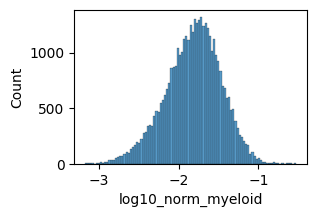

In [15]:
plt.rcParams['figure.figsize'] = (3, 2)
sns.histplot(adata[adata.obs.log10_norm_myeloid>-4].obs.log10_norm_myeloid)

In [16]:
mode_threshold = adata[adata.obs.log10_norm_myeloid>-4].obs.log10_norm_myeloid.mode().tolist()[0]

print('mode = ',mode_threshold)

mode =  -1.6607646942138672


In [17]:
adata.obs['tumor_boundary']=(adata.obs.log10_norm_myeloid>mode_threshold)*1 # binarize based on this threshold

In [18]:
gene_count_threshold = 200

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)

sc.pl.spatial(adata[adata.obs.log10_genes>np.log10(gene_count_threshold)], color='tumor_boundary', spot_size=30, show=False, 
              crop_coord=crop, colorbar_loc=None, cmap='plasma', alpha=.6, alpha_img=.8)
plt.savefig(f'{slideseq}/{fold}/{puck}_tumor_boundary.png',bbox_inches='tight');

# switch to windows

In [163]:
# open the png file in Paint
# carefully remove all boundaries outside of the square (inclusing the square)
# depending on the size used for saving image it won't be 5000x5000 but should be square
# use resize feature in Paint to resize it from say 400x400 to 5000x5000 and save it as JPG

In [164]:
# open the 5k x 5k jpg file in ImageScope and make annotations
# use export Annoations in ImageScope to store them in XML file
# each region will have it vertices saved
# these coordinates can be converted to shapes using the functions below

# parse XML file into regions

In [20]:
tree = ET.parse(f'{slideseq}/{fold}/{puck}_tumor_boundary.xml')
root = tree.getroot()

slide = Image.open(f'{slideseq}/{fold}/{puck}_tumor_boundary.jpg')
size = slide.size
print(size)

(5000, 5000)


In [21]:
# each region will have its own mask saved in a binary png file of 5k x 5k size

for i,r in enumerate(root.iter('Region')):
    print(i,r)
    pts = []
    for p in r.iter('Vertex'):
        x = p.get('X')
        y = p.get('Y')
        pts.append([x, y])

    mask = np.ones((size[1], size[0]))*255

    cv2.fillPoly(mask, np.array([pts], 'int32'), 0)

    im=mask.astype(np.uint8)
    im = Image.fromarray(im)
    im.save(f'{slideseq}/{fold}/{puck}_region_{i}_mask.png')

0 <Element 'Region' at 0x7f32b93beb30>
1 <Element 'Region' at 0x7f32b9307170>
2 <Element 'Region' at 0x7f32b9255230>
3 <Element 'Region' at 0x7f32b91613b0>


In [22]:
all_coords = adata.obsm['spatial']
for i in range(4):
    print(i)
    tumor = Image.open(f'{slideseq}/{fold}/{puck}_region_{i}_mask.png')
    arr=np.array(tumor)
    spots = []
    for c in all_coords:
        if arr[int(c[1]),int(c[0])]==0:
            spots.append(f'region_{i}')
        else:
            spots.append(np.nan)
    adata.obs[f'region_{i}']=spots

0
1
2
3


In [23]:
regions = {}
for i in range(4):
    regions[i] = adata.obs[f'region_{i}']

In [24]:
# based on out annotations regions 0 1 2 are empty areas and region 3 is myeloid high area

In [25]:
adata.obs['Empty']= (~regions[0].isna()) | (~regions[1].isna()) | (~regions[2].isna())
adata.obs['Empty'] = adata.obs['Empty']*1

In [26]:
adata.obs['Empty'].sum()

15575

In [27]:
adata.obs['Boundary'] = ~regions[3].isna()
adata.obs['Boundary'] = adata.obs['Boundary']*2

In [28]:
adata.obs['Spot_class'] = adata.obs['Boundary']+adata.obs['Empty']

In [29]:
adata.obs['Spot_class'].value_counts()

0    20498
1    13504
2    12456
3     2071
Name: Spot_class, dtype: int64

In [30]:
dict_region={0:'Tumor',1:'Empty',2:'Boundary',3:'Empty'}

In [31]:
dict_region

{0: 'Tumor', 1: 'Empty', 2: 'Boundary', 3: 'Empty'}

In [32]:
adata.obs['Spot_names'] = adata.obs['Spot_class'].apply(lambda x: dict_region[x])

In [ ]:
sc.pl.spatial(adata, color='Spot_class', spot_size=30, show=False, crop_coord=crop, 
               cmap='plasma', alpha=.6, alpha_img=.8)

[<AxesSubplot:title={'center':'Spot_names'}, xlabel='spatial1', ylabel='spatial2'>]

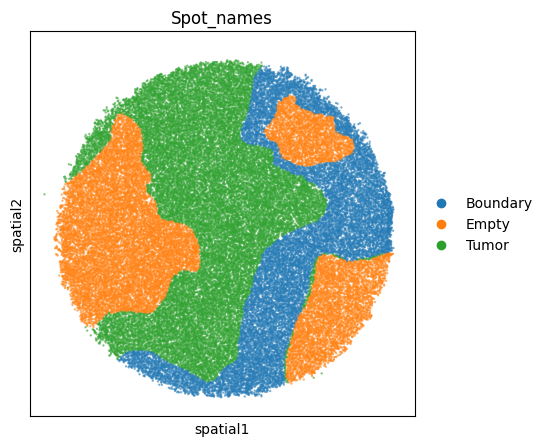

In [34]:
sc.pl.spatial(adata, color='Spot_names', spot_size=30, show=False, crop_coord=crop, 
               cmap='plasma', alpha=.6, alpha_img=.8)

In [ ]:
gene='CD74'
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.spatial(adata[adata[:,gene].X>1], color=gene, spot_size=50, show=False, crop_coord=crop,colorbar_loc=None,
                              cmap='plasma', alpha=.6, alpha_img=.8)


In [36]:
adata.obs['Spot_names'].to_csv(f'{slideseq}/{fold}/{puck}_spot_names.csv')

In [37]:
pd.read_csv(f'{slideseq}/{fold}/{puck}_spot_names.csv',index_col=0)

,Spot_names
ACTCGCAGCCTGGT-1,Boundary
CCTACNATGGCCCG-1,Tumor
CAGNGATAAAGGTA-1,Boundary
GAGTATCACTACCG-1,Tumor
ACCCGAAGCAGTAC-1,Tumor
...,...
CGTTCGATTCATGT-1,Empty
CAANAACTAGCGAG-1,Empty
TGTGCTGCCTTACA-1,Empty
TATTTCCAATGCGT-1,Empty
